<a href="https://colab.research.google.com/github/annisadiyann/UAP-ML-064/blob/main/UAP_RUMAH_ADAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import gc
import os
import cv2
import shutil

In [4]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Colab Notebooks/UAP ML/rumah_adat'

Mounted at /content/drive


In [6]:
def load_dataset(dataset_path):
  """Loads the dataset from the given path.

  Args:
    dataset_path: Path to the dataset directory.

  Returns:
    A tuple containing the image data and corresponding labels.
  """

  images = []
  labels = []

  class_names = os.listdir(dataset_path)
  for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
      for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
          # Resize images to a consistent size
          image = cv2.resize(image, (224, 224))  # Example size, adjust as needed
          images.append(image)
          labels.append(class_name)

  return np.array(images), np.array(labels)


# Load the dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/UAP ML/rumah_adat'
images, labels = load_dataset(dataset_path)

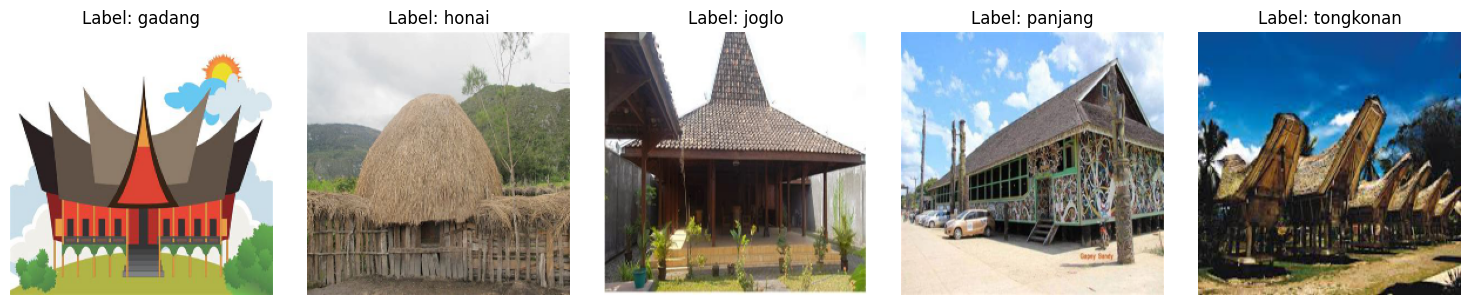

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

unique_labels = np.unique(labels)

num_cols = 5
num_rows = (len(unique_labels) + num_cols - 1) // num_cols  # Hitung jumlah baris

plt.figure(figsize=(15, num_rows * 3))  # Sesuaikan ukuran grid
for i, label in enumerate(unique_labels):
    # Cari indeks gambar yang sesuai dengan label saat ini
    indices = np.where(labels == label)[0]

    # Pilih gambar acak dari label tersebut
    random_index = np.random.choice(indices)
    image = images[random_index]

    # Tambahkan subplot untuk setiap gambar
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Konversi dari BGR ke RGB
    plt.title(f"Label: {label}")
    plt.axis("off")  # Hilangkan sumbu

plt.tight_layout()  # Tata letak agar lebih rapi
plt.show()


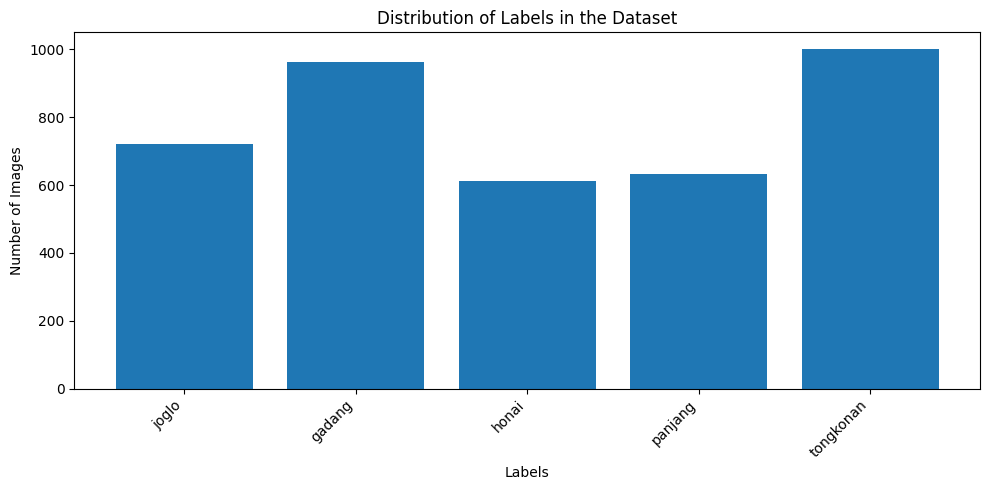

In [8]:
# Calculate the distribution of labels
label_counts = {}
for label in labels:
  if label not in label_counts:
    label_counts[label] = 0
  label_counts[label] += 1

# Create a bar chart to visualize the label distribution
plt.figure(figsize=(10, 5))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Labels")
plt.ylabel("Number of Images")
plt.title("Distribution of Labels in the Dataset")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

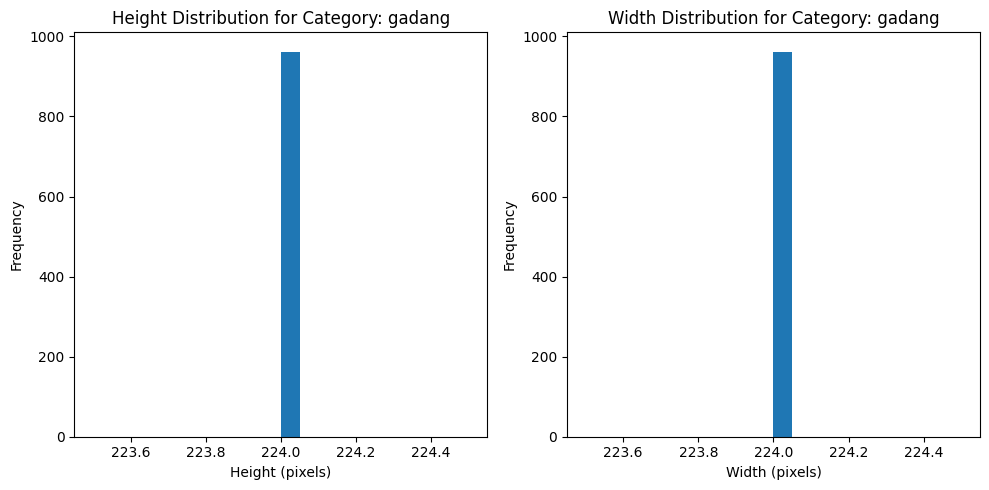

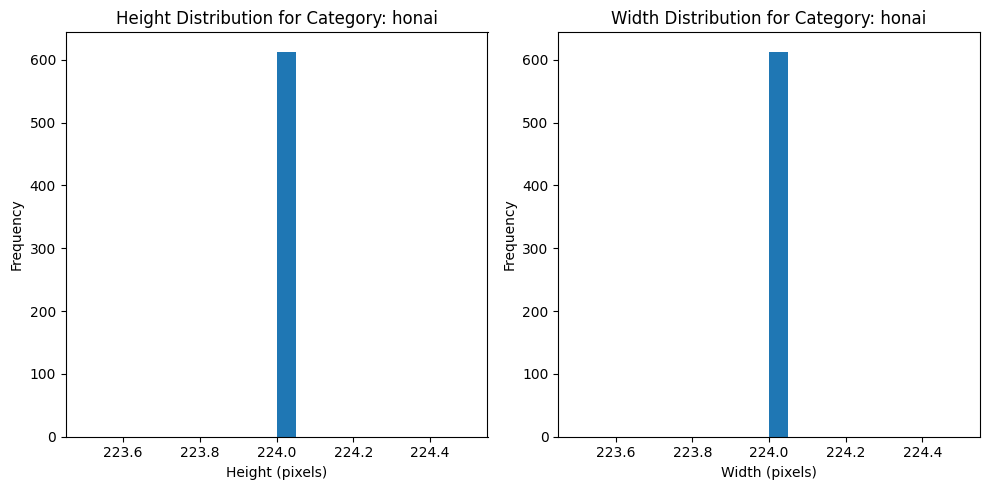

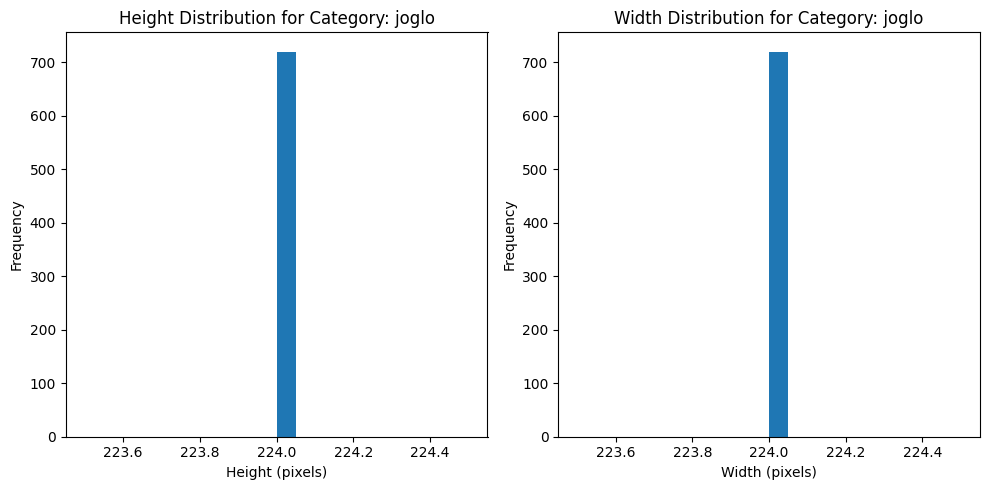

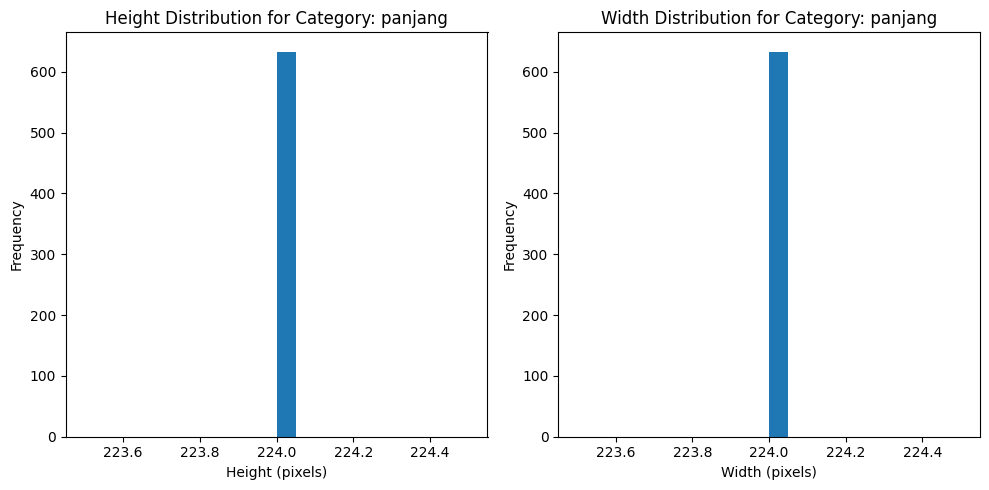

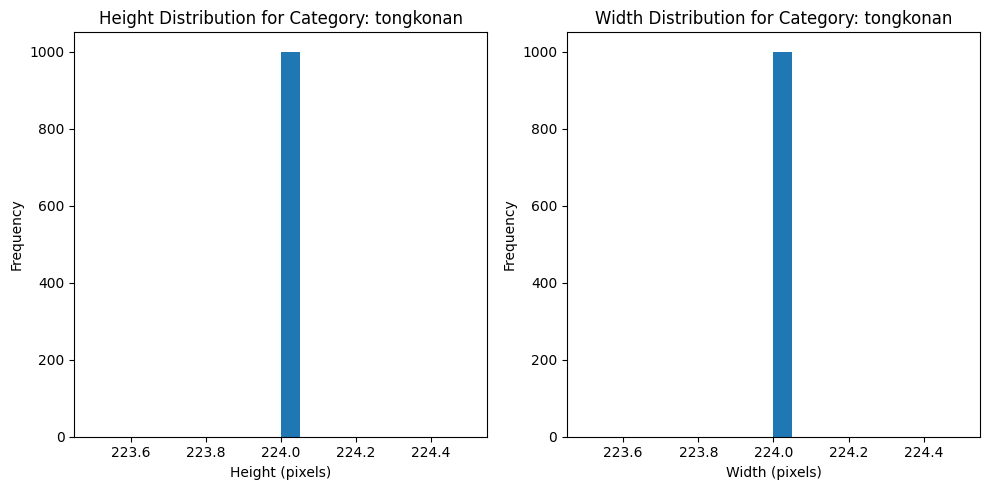

In [9]:
for label in unique_labels:
  # Find indices of images belonging to the current label
  indices = np.where(labels == label)[0]

  # Extract images for the current label
  label_images = images[indices]

  # Get image dimensions
  image_heights = [img.shape[0] for img in label_images]
  image_widths = [img.shape[1] for img in label_images]

  # Plot the distribution of image heights and widths
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.hist(image_heights, bins=20)
  plt.xlabel("Height (pixels)")
  plt.ylabel("Frequency")
  plt.title(f"Height Distribution for Category: {label}")

  plt.subplot(1, 2, 2)
  plt.hist(image_widths, bins=20)
  plt.xlabel("Width (pixels)")
  plt.ylabel("Frequency")
  plt.title(f"Width Distribution for Category: {label}")

  plt.tight_layout()
  plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


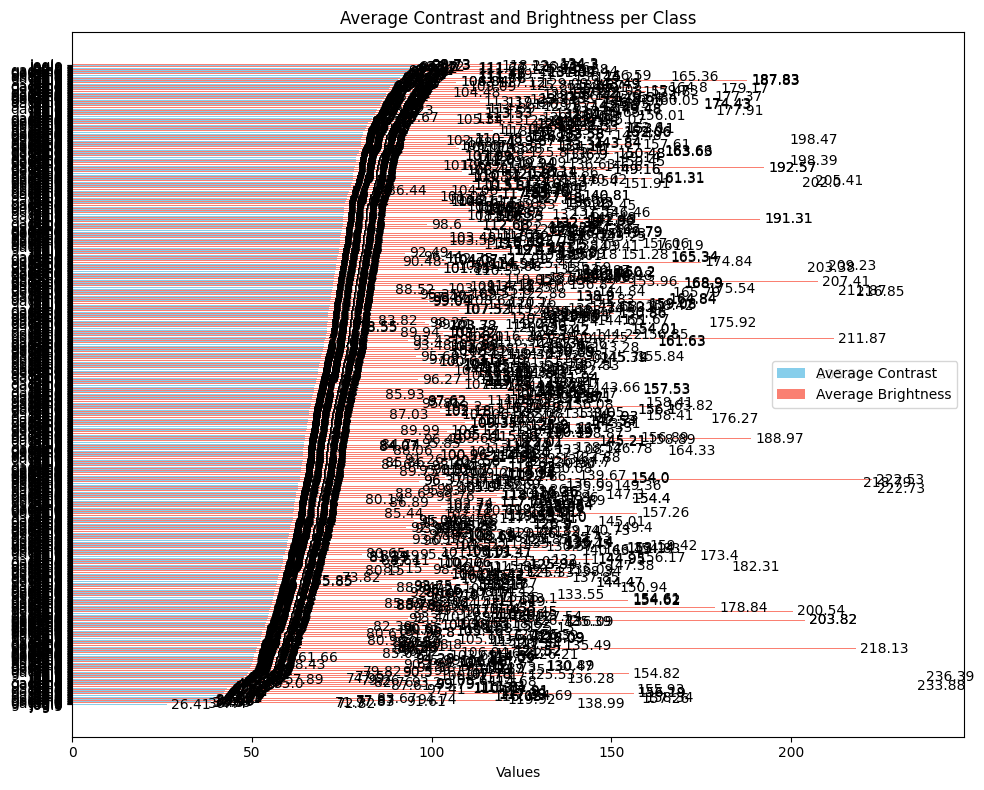

In [10]:
def calculate_average_contrast_brightness(images):
    """Calculates the average contrast and brightness for a list of images."""
    contrasts = []
    brightnesses = []
    for img in images:
        if img is None:  # Skip invalid images
            continue
        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Calculate contrast using standard deviation
        contrast = np.std(gray)
        contrasts.append(contrast)

        # Calculate brightness using mean pixel intensity
        brightness = np.mean(gray)
        brightnesses.append(brightness)

    return np.array(contrasts), np.array(brightnesses)

unique_labels = np.unique(labels)
avg_contrasts_per_class = {}
avg_brightnesses_per_class = {}

for label in unique_labels:
    # Get images for the current label
    class_images = images[labels == label]
    if len(class_images) == 0:
        print(f"Skipping label: {label} (no images)")
        continue

    # Calculate average contrast and brightness for the images in this class
    contrasts, brightnesses = calculate_average_contrast_brightness(class_images)
    avg_contrasts_per_class[label] = np.mean(contrasts)
    avg_brightnesses_per_class[label] = np.mean(brightnesses)

# Sort data by contrast for better visualization
if len(contrasts) > 0 and len(brightnesses) > 0:
    sorted_indices = np.argsort(contrasts)
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_contrasts = [contrasts[i] for i in sorted_indices]
    sorted_brightnesses = [brightnesses[i] for i in sorted_indices]
else:
    print("No valid data for plotting.")
    sorted_labels, sorted_contrasts, sorted_brightnesses = [], [], []

# Plotting (if there is valid data)
if len(sorted_labels) > 0:
    x = np.arange(len(sorted_labels))  # the label locations

    fig, ax = plt.subplots(figsize=(10, 8))

    # Create horizontal bars
    rects1 = ax.barh(x - 0.2, sorted_contrasts, 0.4, label='Average Contrast', color='skyblue')
    rects2 = ax.barh(x + 0.2, sorted_brightnesses, 0.4, label='Average Brightness', color='salmon')

    # Add labels, title, and legend
    ax.set_xlabel('Values')
    ax.set_title('Average Contrast and Brightness per Class')
    ax.set_yticks(x)
    ax.set_yticklabels(sorted_labels)
    ax.legend()

    # Add labels above bars
    def autolabel_horizontal(rects):
        for rect in rects:
            width = rect.get_width()
            ax.annotate('{}'.format(round(width, 2)),
                        xy=(width, rect.get_y() + rect.get_height() / 2),
                        xytext=(3, 0),
                        textcoords="offset points",
                        ha='left', va='center')

    autolabel_horizontal(rects1)
    autolabel_horizontal(rects2)

    fig.tight_layout()
    plt.show()

In [11]:
import os
import random

# Path ke dataset
base_path = '/content/drive/MyDrive/Colab Notebooks/UAP ML/rumah_adat'

# Jumlah target maksimal per kelas
target_count = 500

# Menghapus gambar berlebih
for label in os.listdir(base_path):
    label_path = os.path.join(base_path, label)
    if os.path.isdir(label_path):
        # Mendapatkan file gambar di folder kelas
        files = os.listdir(label_path)
        current_count = len(files)

        # Jika jumlah gambar lebih dari target_count
        if current_count > target_count:
            print(f"Menghapus {current_count - target_count} gambar dari kelas {label}...")

            # Memilih gambar secara acak untuk dihapus
            files_to_delete = random.sample(files, current_count - target_count)
            for file_name in files_to_delete:
                file_path = os.path.join(label_path, file_name)
                os.remove(file_path)

print("Penghapusan gambar berlebih selesai!")


Menghapus 220 gambar dari kelas joglo...
Menghapus 462 gambar dari kelas gadang...
Menghapus 113 gambar dari kelas honai...
Menghapus 133 gambar dari kelas panjang...
Menghapus 500 gambar dari kelas tongkonan...
Penghapusan gambar berlebih selesai!


In [12]:
import cv2
import os
import random
import numpy as np

def color_jitter(image, brightness=0, contrast=0, saturation=0, hue=0):
    """Applies color jittering to an image."""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)

    if brightness != 0:
        image[:,:,2] = np.clip(image[:,:,2] * (1 + brightness), 0, 255)

    if contrast != 0:
        mean = np.mean(image[:,:,2])
        image[:,:,2] = np.clip((image[:,:,2] - mean) * (1 + contrast) + mean, 0, 255)

    if saturation != 0:
        image[:,:,1] = np.clip(image[:,:,1] * (1 + saturation), 0, 255)

    if hue != 0:
        image[:,:,0] = (image[:,:,0] + hue * 180) % 180

    image = cv2.cvtColor(np.clip(image, 0, 255).astype(np.uint8), cv2.COLOR_HSV2BGR)

    return image

def augment_image_with_jitter(img, brightness_factor, contrast_factor, saturation_factor, hue_factor):
    """Augments the image by applying color jitter."""
    return color_jitter(img, brightness=brightness_factor, contrast=contrast_factor, saturation=saturation_factor, hue=hue_factor)

def generate_augmented_dataset(input_dir, output_dir, ratio=4, brightness_range=(-0.2, 0.2), contrast_range=(-0.2, 0.2), saturation_range=(-0.2, 0.2), hue_range=(-0.05, 0.05)):
    """Generates augmented dataset using color jittering for brightness, contrast, saturation, and hue adjustments."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_label in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_label)
        output_class_dir = os.path.join(output_dir, class_label)

        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        # Load all images in the class
        images = []
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                else:
                    print(f"Failed to load image: {img_path}")

        if not images:
            print(f"No valid images in directory: {class_dir}")
            continue

        num_original_images = len(images)
        num_augmented_per_image = ratio

        for idx, img in enumerate(images):
            # Save the original image
            original_path = os.path.join(output_class_dir, f"{class_label}_original_{idx}.jpg")
            cv2.imwrite(original_path, img)

            # Generate augmented images using color jittering
            for i in range(num_augmented_per_image):
                brightness_factor = random.uniform(*brightness_range)
                contrast_factor = random.uniform(*contrast_range)
                saturation_factor = random.uniform(*saturation_range)
                hue_factor = random.uniform(*hue_range)

                augmented_img = augment_image_with_jitter(img, brightness_factor, contrast_factor, saturation_factor, hue_factor)

                augmented_path = os.path.join(output_class_dir, f"{class_label}_augmented_{idx}_{i}.jpg")
                cv2.imwrite(augmented_path, augmented_img)

# Define input and output directories
input_dir = '/content/drive/MyDrive/Colab Notebooks/UAP ML/rumah_adat'
output_dir = '/content/drive/MyDrive/Colab Notebooks/UAP ML/augmentasi'

# Generate augmented dataset with a ratio of 1:1
generate_augmented_dataset(input_dir, output_dir, ratio=3)


In [14]:
def split_dataset(source_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Splits a dataset into training, validation, and testing sets.

    Args:
        source_dir: Path to the source dataset directory.
        train_dir: Path to the directory for the training set.
        val_dir: Path to the directory for the validation set.
        test_dir: Path to the directory for the testing set.
        train_ratio: Proportion of data for training.
        val_ratio: Proportion of data for validation.
        test_ratio: Proportion of data for testing.
    """

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            random.shuffle(images)
            num_images = len(images)
            num_train = int(num_images * train_ratio)
            num_val = int(num_images * val_ratio)
            num_test = num_images - num_train - num_val

            for i, image in enumerate(images):
                source_image_path = os.path.join(class_path, image)
                if i < num_train:
                    destination_image_path = os.path.join(train_class_dir, image)
                elif i < num_train + num_val:
                    destination_image_path = os.path.join(val_class_dir, image)
                else:
                    destination_image_path = os.path.join(test_class_dir, image)

                shutil.copy(source_image_path, destination_image_path)

# Example usage
source_directory = '/content/drive/MyDrive/Colab Notebooks/UAP ML/augmentasi'  # Replace with the path to your dataset
train_directory = '/content/drive/MyDrive/Colab Notebooks/UAP ML/split/train'
validation_directory = '/content/drive/MyDrive/Colab Notebooks/UAP ML/split/validation'
test_directory = '/content/drive/MyDrive/Colab Notebooks/UAP ML/split/test'

split_dataset(source_directory, train_directory, validation_directory, test_directory)

#CNN

In [15]:
# Memory cleanup and GPU settings
def setup_gpu():
    tf.keras.backend.clear_session()
    gc.collect()

    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Limit GPU memory to 3GB
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=3072)]
            )
    except:
        pass

setup_gpu()

In [16]:
# Directory settings
base_dir = '/content/drive/MyDrive/Colab Notebooks/UAP ML/split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print("Class names:", train_generator.class_indices)

Found 7000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Number of classes: 5
Class names: {'gadang': 0, 'honai': 1, 'joglo': 2, 'panjang': 3, 'tongkonan': 4}


In [17]:
# Efficient CNN Model
model = Sequential([
    # First Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Third Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Fourth Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    # Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Use mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Compile model
optimizer = Adam(learning_rate=0.001)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,085,573 (99.51 MB)

 Trainable params: 26,083,589 (99.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [18]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Training
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 168s 340ms/step - accuracy: 0.4122 - loss: 1.9367 - val_accuracy: 0.3580 - val_loss: 2.5162 - learning_rate: 0.0010
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 146s 334ms/step - accuracy: 0.6668 - loss: 0.9342 - val_accuracy: 0.7520 - val_loss: 0.6766 - learning_rate: 0.0010
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 130s 297ms/step - accuracy: 0.7520 - loss: 0.7098 - val_accuracy: 0.8513 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 126s 287ms/step - accuracy: 0.8005 - loss: 0.5611 - val_accuracy: 0.9153 - val_loss: 0.2599 - learning_rate: 0.0010
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 162s 333ms/step - accuracy: 0.8500 - loss: 0.4345 - val_accuracy: 0.8147 - val_loss: 0.5674 - learning_rate: 0.0010
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 131s 300ms/step - accuracy: 0.8616 - loss: 0.4047 - val_accuracy: 0.6327 - val_loss: 1.4440 - learning_rate: 0.0010
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 136s 311ms/step - accura

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step

Classification Report:
              precision    recall  f1-score   support

      gadang       0.98      0.85      0.91       300
       honai       0.97      0.91      0.94       300
       joglo       0.91      0.93      0.92       300
     panjang       0.84      0.94      0.89       300
   tongkonan       0.90      0.95      0.93       300

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



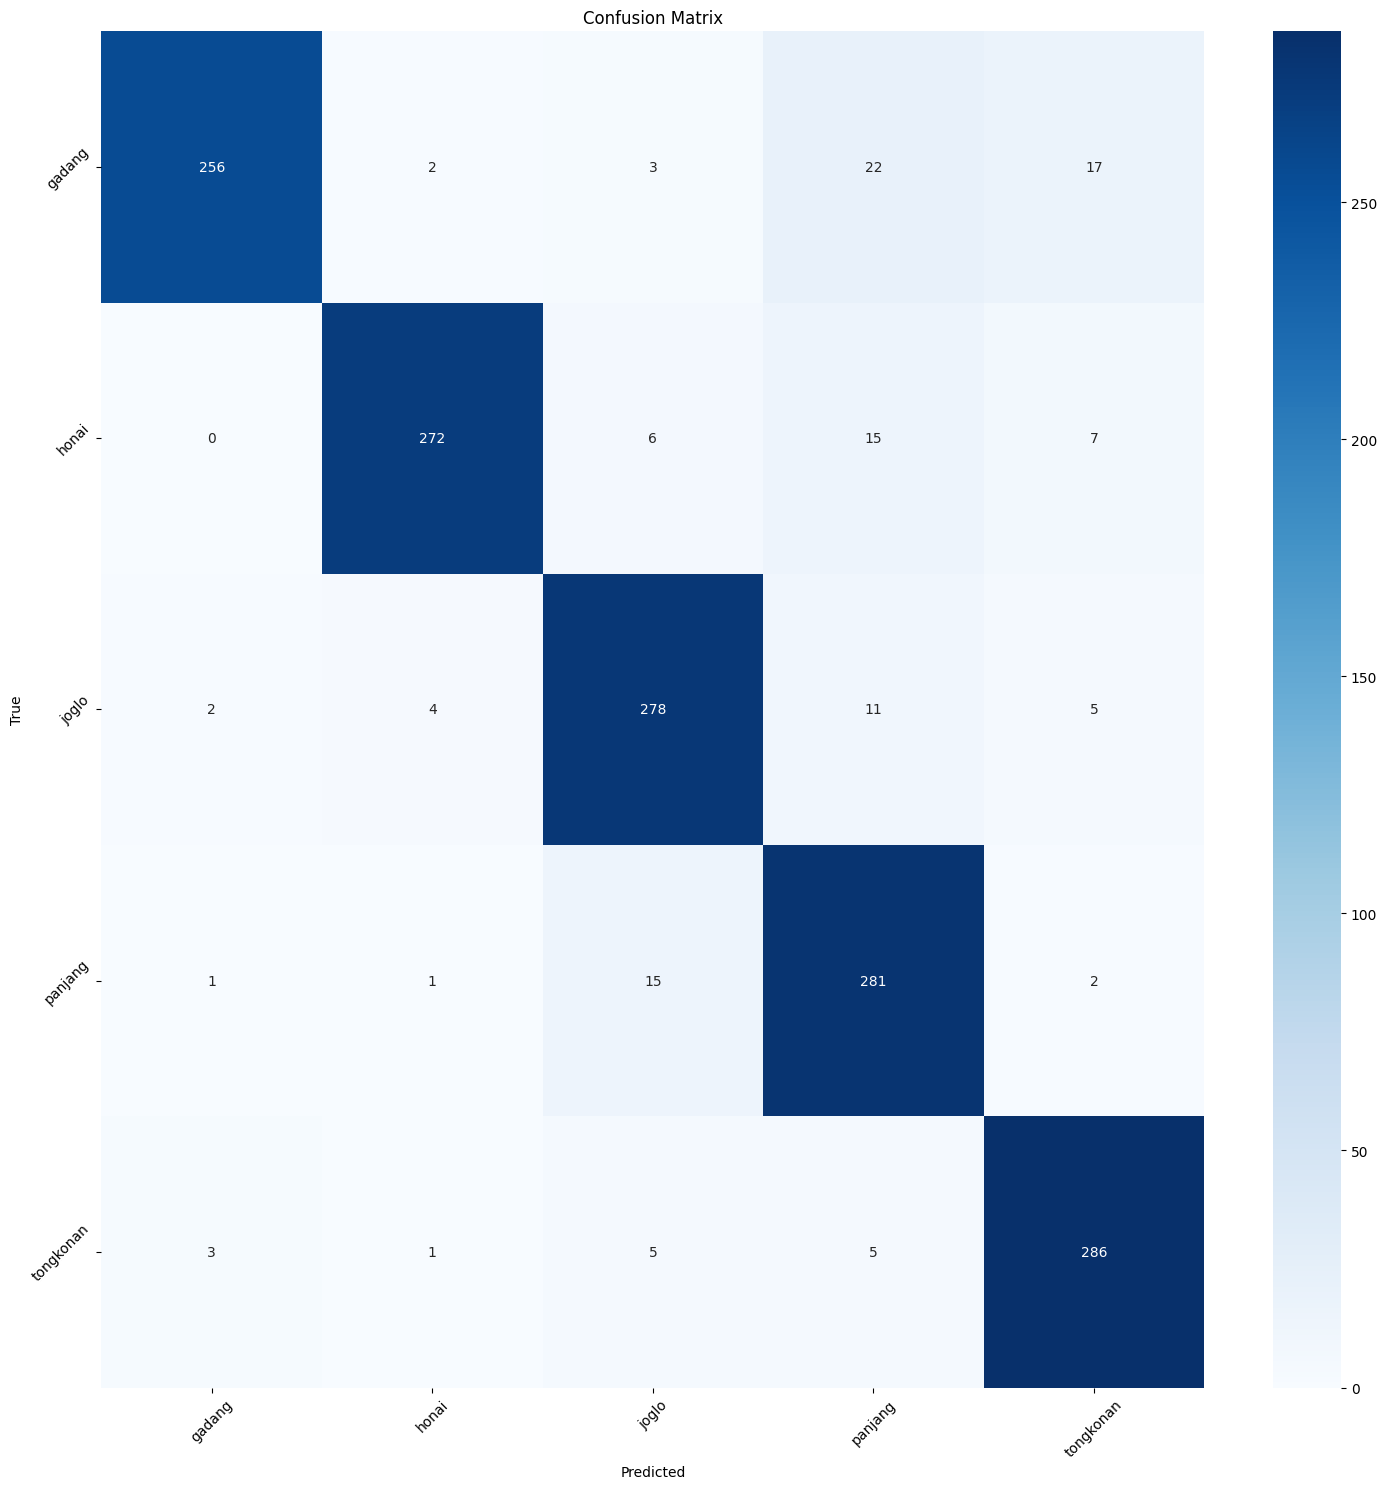

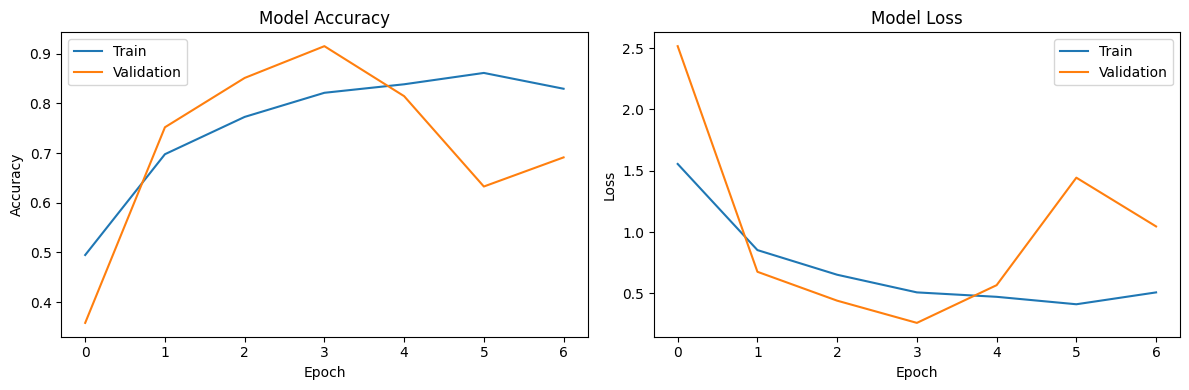

In [19]:
# Evaluate the model
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Classification Report
print("\nClassification Report:")
class_names = list(train_generator.class_indices.keys())
cr = classification_report(y_true, y_pred, target_names=class_names)
print(cr)

# Confusion Matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Training History Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [20]:
# Tentukan direktori tempat menyimpan model di Drive
save_dir = '/content/drive/MyDrive/Colab Notebooks/UAP ML/models'

# Buat folder jika belum ada
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Nama file model
model_name = 'omah_classification_model_v1.h5'
full_save_path = os.path.join(save_dir, model_name)

# Simpan model
model.save(full_save_path)

print(f"Model berhasil disimpan di: {full_save_path}")

Model berhasil disimpan di: /content/drive/MyDrive/Colab Notebooks/UAP ML/models/omah_classification_model_v1.h5


#RESNET50

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Konfigurasi Mixed Precision agar training lebih cepat
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Tentukan direktori penyimpanan model di Drive
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/UAP ML/models'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

print("Setup GPU dan Library Selesai.")

Setup GPU dan Library Selesai.


In [22]:
IMG_SIZE = 224
BATCH_SIZE = 16

# Data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load dataset
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/UAP ML/augmentasi',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/UAP ML/augmentasi',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)
print(f"Dataset dimuat. Jumlah kelas: {NUM_CLASSES}")

Found 8000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Dataset dimuat. Jumlah kelas: 5


In [23]:
def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Freeze base model awal

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

model, base_model = create_model()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,769,413 (94.49 MB)

 Trainable params: 1,181,701 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
# Callbacks Fase 1
early_stopping_f1 = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
checkpoint_f1 = ModelCheckpoint(os.path.join(SAVE_DIR, 'resnet_fase1.h5'), monitor='val_accuracy', save_best_only=True, verbose=1)

print("Starting Phase 1: Training top layers (5 Epochs)")
history1 = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping_f1, reduce_lr, checkpoint_f1]
)

Starting Phase 1: Training top layers (5 Epochs)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7859 - loss: 0.6522
Epoch 1: val_accuracy improved from -inf to 0.96150, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/resnet_fase1.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 205s 375ms/step - accuracy: 0.7861 - loss: 0.6516 - val_accuracy: 0.9615 - val_loss: 0.1133 - learning_rate: 0.0010
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9511 - loss: 0.1553
Epoch 2: val_accuracy did not improve from 0.96150
500/500 ━━━━━━━━━━━━━━━━━━━━ 167s 333ms/step - accuracy: 0.9511 - loss: 0.1552 - val_accuracy: 0.9245 - val_loss: 0.2614 - learning_rate: 0.0010
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9677 - loss: 0.1047
Epoch 3: val_accuracy improved from 0.96150 to 0.97300, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/resnet_fase1.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 318ms/step - accuracy: 0.9677 - loss: 0.1047 - val_accuracy: 0.9730 - val_loss: 0.0764 - learning_rate: 0.0010
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9677 - loss: 0.1072
Epoch 4: val_accuracy did not improve from 0.97300
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 319ms/step - accuracy: 0.9677 - loss: 0.1072 - val_accuracy: 0.9710 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9676 - loss: 0.1052
Epoch 5: val_accuracy did not improve from 0.97300
500/500 ━━━━━━━━━━━━━━━━━━━━ 157s 314ms/step - accuracy: 0.9676 - loss: 0.1052 - val_accuracy: 0.9730 - val_loss: 0.0734 - learning_rate: 0.0010


In [25]:
print("Starting Phase 2: Fine-tuning ResNet layers (5 Epochs)")

# Unfreeze 30 layer terakhir
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile dengan Learning Rate lebih rendah (0.0001)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_final = ModelCheckpoint(os.path.join(SAVE_DIR, 'resnet_final_best.h5'), monitor='val_accuracy', save_best_only=True, verbose=1)

history2 = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[reduce_lr, checkpoint_final] # Tanpa EarlyStopping agar pasti jalan 5 kali
)

Starting Phase 2: Fine-tuning ResNet layers (5 Epochs)
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9670 - loss: 0.1200
Epoch 1: val_accuracy improved from -inf to 0.98750, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/resnet_final_best.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 192s 331ms/step - accuracy: 0.9670 - loss: 0.1200 - val_accuracy: 0.9875 - val_loss: 0.0364 - learning_rate: 1.0000e-04
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9902 - loss: 0.0392
Epoch 2: val_accuracy improved from 0.98750 to 0.99200, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/resnet_final_best.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 167s 334ms/step - accuracy: 0.9902 - loss: 0.0392 - val_accuracy: 0.9920 - val_loss: 0.0489 - learning_rate: 1.0000e-04
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9947 - loss: 0.0215
Epoch 3: val_accuracy improved from 0.99200 to 0.99600, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/resnet_final_best.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 335ms/step - accuracy: 0.9947 - loss: 0.0215 - val_accuracy: 0.9960 - val_loss: 0.0164 - learning_rate: 1.0000e-04
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9938 - loss: 0.0231
Epoch 4: val_accuracy improved from 0.99600 to 0.99750, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/resnet_final_best.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 165s 331ms/step - accuracy: 0.9938 - loss: 0.0231 - val_accuracy: 0.9975 - val_loss: 0.0083 - learning_rate: 1.0000e-04
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9978 - loss: 0.0088
Epoch 5: val_accuracy did not improve from 0.99750
500/500 ━━━━━━━━━━━━━━━━━━━━ 164s 328ms/step - accuracy: 0.9978 - loss: 0.0088 - val_accuracy: 0.9975 - val_loss: 0.0087 - learning_rate: 1.0000e-04


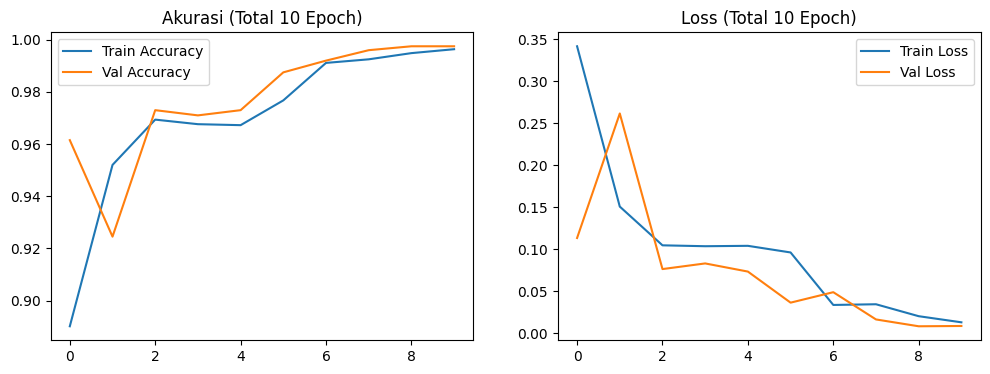

125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 248ms/step

Classification Report:
              precision    recall  f1-score   support

      gadang       1.00      0.99      1.00       400
       honai       1.00      1.00      1.00       400
       joglo       0.99      0.99      0.99       400
     panjang       1.00      0.99      0.99       400
   tongkonan       1.00      1.00      1.00       400

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



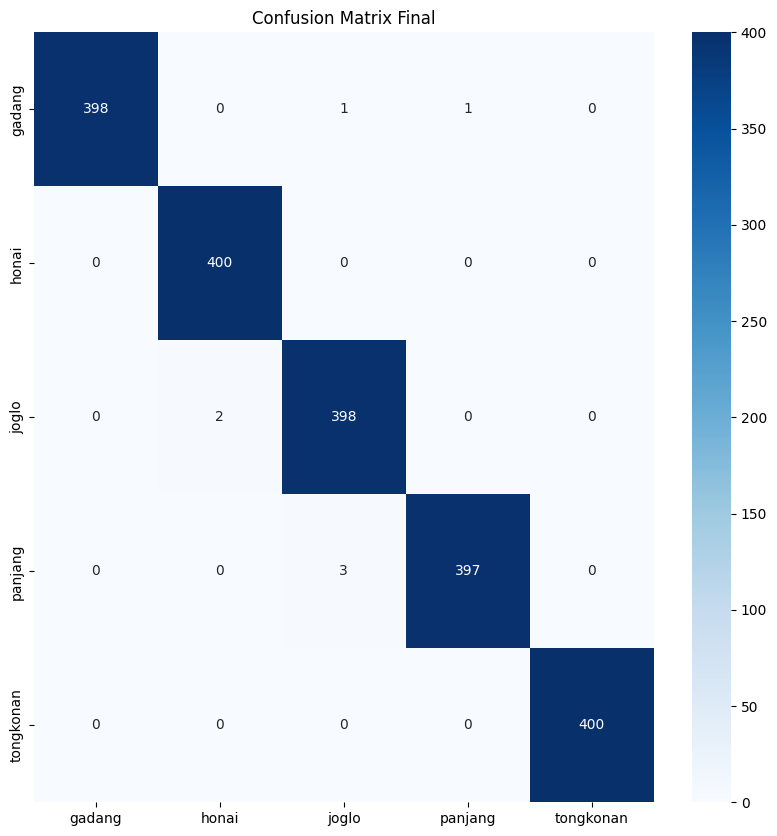

In [26]:
# 1. Plot History Gabungan
def plot_training_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title('Akurasi (Total 10 Epoch)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss (Total 10 Epoch)')
    plt.legend()
    plt.show()

plot_training_history(history1, history2)

# 2. Classification Report & Confusion Matrix
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
class_names = list(train_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Final')
plt.show()

# Simpan model final lengkap
model.save(os.path.join(SAVE_DIR, 'model_omah_resnet_final.h5'))

#VGG16

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Setup Mixed Precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Tentukan direktori penyimpanan model di Drive
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/UAP ML/models'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

print("Setup VGG16 Selesai.")

Setup VGG16 Selesai.


In [28]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input, # Preprocessing VGG
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/UAP ML/augmentasi',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/UAP ML/augmentasi',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)

Found 8000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [29]:
def create_vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Freeze base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

model, base_model = create_vgg_model()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,109,957 (57.64 MB)

 Trainable params: 395,269 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
checkpoint_vgg_f1 = ModelCheckpoint(os.path.join(SAVE_DIR, 'vgg16_fase1.h5'), monitor='val_accuracy', save_best_only=True, verbose=1)

print("Phase 1: Training VGG Classifier (5 Epochs)")
history1 = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint_vgg_f1]
)

Phase 1: Training VGG Classifier (5 Epochs)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6936 - loss: 1.6419
Epoch 1: val_accuracy improved from -inf to 0.93200, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/vgg16_fase1.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 185s 351ms/step - accuracy: 0.6939 - loss: 1.6401 - val_accuracy: 0.9320 - val_loss: 0.2139 - learning_rate: 0.0010
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9374 - loss: 0.2057
Epoch 2: val_accuracy improved from 0.93200 to 0.95850, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/vgg16_fase1.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 161s 322ms/step - accuracy: 0.9374 - loss: 0.2056 - val_accuracy: 0.9585 - val_loss: 0.1220 - learning_rate: 0.0010
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9567 - loss: 0.1342
Epoch 3: val_accuracy did not improve from 0.95850
500/500 ━━━━━━━━━━━━━━━━━━━━ 160s 320ms/step - accuracy: 0.9567 - loss: 0.1342 - val_accuracy: 0.9495 - val_loss: 0.1284 - learning_rate: 0.0010
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9601 - loss: 0.1297
Epoch 4: val_accuracy improved from 0.95850 to 0.96350, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/vgg16_fase1.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 161s 323ms/step - accuracy: 0.9601 - loss: 0.1297 - val_accuracy: 0.9635 - val_loss: 0.0946 - learning_rate: 0.0010
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9609 - loss: 0.1255
Epoch 5: val_accuracy did not improve from 0.96350
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 319ms/step - accuracy: 0.9609 - loss: 0.1255 - val_accuracy: 0.9590 - val_loss: 0.1102 - learning_rate: 0.0010


In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
checkpoint_vgg_f1 = ModelCheckpoint(os.path.join(SAVE_DIR, 'vgg16_fase1.h5'), monitor='val_accuracy', save_best_only=True, verbose=1)

print("Phase 1: Training VGG Classifier (5 Epochs)")
history1 = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint_vgg_f1]
)

Phase 1: Training VGG Classifier (5 Epochs)
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9630 - loss: 0.1161
Epoch 1: val_accuracy improved from -inf to 0.96450, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/vgg16_fase1.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - accuracy: 0.9630 - loss: 0.1161 - val_accuracy: 0.9645 - val_loss: 0.1247 - learning_rate: 0.0010
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9618 - loss: 0.1128
Epoch 2: val_accuracy improved from 0.96450 to 0.96850, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/vgg16_fase1.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 315ms/step - accuracy: 0.9618 - loss: 0.1128 - val_accuracy: 0.9685 - val_loss: 0.0862 - learning_rate: 0.0010
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9750 - loss: 0.0831
Epoch 3: val_accuracy did not improve from 0.96850
500/500 ━━━━━━━━━━━━━━━━━━━━ 157s 313ms/step - accuracy: 0.9750 - loss: 0.0832 - val_accuracy: 0.9600 - val_loss: 0.1038 - learning_rate: 0.0010
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9709 - loss: 0.0955
Epoch 4: val_accuracy improved from 0.96850 to 0.96900, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/vgg16_fase1.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 157s 314ms/step - accuracy: 0.9709 - loss: 0.0955 - val_accuracy: 0.9690 - val_loss: 0.0913 - learning_rate: 0.0010


In [32]:
print("Phase 2: Fine-tuning VGG16 Block 5 (5 Epochs)")

# Unfreeze 4 layer terakhir (blok konvolusi ke-5 VGG16)
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile dengan LR sangat rendah
model.compile(
    optimizer=Adam(learning_rate=0.00001), # Lebih rendah dari ResNet untuk stabilitas
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_vgg_final = ModelCheckpoint(os.path.join(SAVE_DIR, 'vgg16_final_best.h5'), monitor='val_accuracy', save_best_only=True, verbose=1)

history2 = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[reduce_lr, checkpoint_vgg_final]
)

Phase 2: Fine-tuning VGG16 Block 5 (5 Epochs)
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9789 - loss: 0.0697
Epoch 1: val_accuracy improved from -inf to 0.99200, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/vgg16_final_best.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 167s 318ms/step - accuracy: 0.9789 - loss: 0.0697 - val_accuracy: 0.9920 - val_loss: 0.0296 - learning_rate: 1.0000e-05
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9936 - loss: 0.0224
Epoch 2: val_accuracy improved from 0.99200 to 0.99300, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/vgg16_final_best.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 160s 319ms/step - accuracy: 0.9936 - loss: 0.0224 - val_accuracy: 0.9930 - val_loss: 0.0243 - learning_rate: 1.0000e-05
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9959 - loss: 0.0197
Epoch 3: val_accuracy improved from 0.99300 to 0.99550, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/vgg16_final_best.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 163s 325ms/step - accuracy: 0.9959 - loss: 0.0197 - val_accuracy: 0.9955 - val_loss: 0.0176 - learning_rate: 1.0000e-05
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9967 - loss: 0.0155
Epoch 4: val_accuracy did not improve from 0.99550
500/500 ━━━━━━━━━━━━━━━━━━━━ 161s 320ms/step - accuracy: 0.9967 - loss: 0.0155 - val_accuracy: 0.9940 - val_loss: 0.0225 - learning_rate: 1.0000e-05
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9972 - loss: 0.0118
Epoch 5: val_accuracy improved from 0.99550 to 0.99600, saving model to /content/drive/MyDrive/Colab Notebooks/UAP ML/models/vgg16_final_best.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - accuracy: 0.9972 - loss: 0.0118 - val_accuracy: 0.9960 - val_loss: 0.0125 - learning_rate: 1.0000e-05


125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 261ms/step

Classification Report VGG16:
              precision    recall  f1-score   support

      gadang       1.00      0.99      1.00       400
       honai       1.00      1.00      1.00       400
       joglo       1.00      1.00      1.00       400
     panjang       1.00      1.00      1.00       400
   tongkonan       1.00      1.00      1.00       400

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



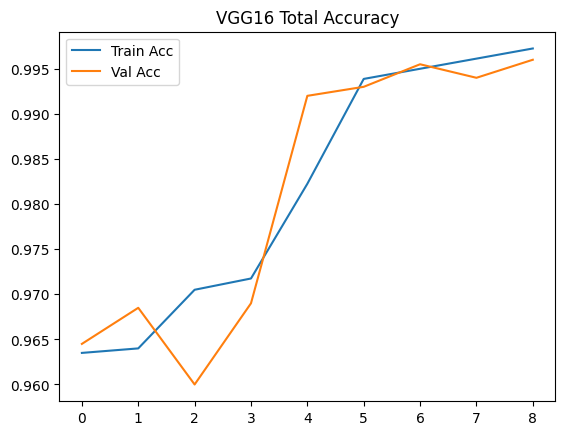

In [33]:
# Evaluasi akhir
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
class_names = list(train_generator.class_indices.keys())

print("\nClassification Report VGG16:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Gabungan
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('VGG16 Total Accuracy')
plt.legend()
plt.show()

# Simpan model final
model.save(os.path.join(SAVE_DIR, 'model_omah_vgg16_final.h5'))

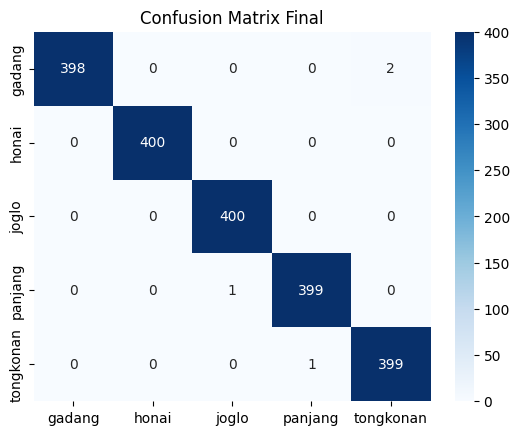

In [35]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Final')
plt.show()